In [2]:
using Revise 
using EuclidianNormalizingFlows

using BAT
using InverseFunctions
using Distributions
using Optimisers
using FunctionChains
using ArraysOfArrays
using LinearAlgebra
using ValueShapes
using StatsBase
using FileIO
using JLD2
using CUDA
using CUDAKernels
using KernelAbstractions
using Flux
using PyPlot


In [3]:
data = load("/home/iwsatlas1/mdud/RQS_experiments/mpg_flow_data_with_grids.jld2")
smpls = data["Samples"]
smpls_t = data["Samples_transformed"]
mpg_flow = data["Flow"]
grid_logo = data["Grid_logo"]
grid_logo_t = data["Grid_logo_transformed"]
grid_n = data["Grid_normal"]
grid_n_t = data["Grid_normal_transformed"]
normals = data["Normals"]
smpls_synth = data["Synthetic_Samples"]

2×350000 Matrix{Float64}:
  293.598   399.15    561.765   253.659  …   391.9   391.887   247.609
 -301.9    -198.724  -278.869  -205.648     -446.2  -192.47   -256.105

# MPG

In [5]:
gpu([1])

LoadError: InterruptException:

In [4]:
mpg_flow

FunctionChain(12-element Vector{Function}:
 (::AdaptiveScaleShift) (generic function with 2 methods)
 (::CouplingRQSBlock) (generic function with 2 methods)
 (::CouplingRQSBlock) (generic function with 2 methods)
 (::AdaptiveScaleShift) (generic function with 2 methods)
 (::AdaptiveScaleShift) (generic function with 2 methods)
 (::CouplingRQSBlock) (generic function with 2 methods)
 (::CouplingRQSBlock) (generic function with 2 methods)
 (::AdaptiveScaleShift) (generic function with 2 methods)
 (::AdaptiveScaleShift) (generic function with 2 methods)
 (::CouplingRQSBlock) (generic function with 2 methods)
 (::CouplingRQSBlock) (generic function with 2 methods)
 (::AdaptiveScaleShift) (generic function with 2 methods))

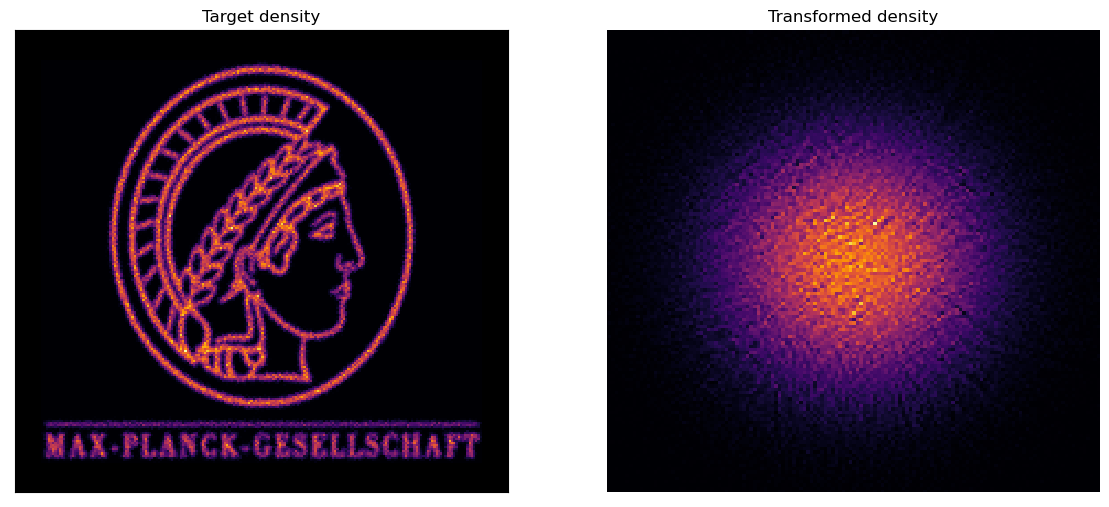

(-3.0, 3.0)

In [19]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[1].set_title("Target density")
ax[1].hist2d(smpls[1,:], smpls[2,:], [200,200], cmap="inferno")
ax[1].set_xlim([minimum(smpls[1,:])-30, maximum(smpls[1,:])+30])
ax[1].set_ylim([minimum(smpls[2,:])-30, maximum(smpls[2,:])+30])
ax[1].set_facecolor("black")
ax[1].get_xaxis().set_visible(false)
ax[1].get_yaxis().set_visible(false)
ax[2].hist2d(mpg_flow(smpls)[1,:], mpg_flow(smpls)[2,:], [200,200], cmap="inferno")
ax[2].set_title("Transformed density")
ax[2].axis("off")
ax[2].set_xlim([-3, 3])
ax[2].set_ylim([-3, 3])

In [365]:
pd = 10000
ys = collect(range(-50, -550, pd))
xs = collect(range(100, 700, pd))
ts = 25

grid_logo = [150 150; -510 -510]
lc = 0 

for x in 100:ts:700
    grid_logo = hcat(grid_logo, vcat(fill(x, 1, pd), reshape(ys, 1, length(ys))))    
    lc += 1
end

for y in -550:ts:(-50)
    grid_logo = hcat(grid_logo, vcat(reshape(xs, 1, length(xs)), fill(y, 1, pd)))
    lc+=1
end
grid_logo_t = gpu.(mpg_flow)(gpu(grid_logo))

In [7]:
size(grid_n,2)/100

162000.02

In [5]:
pd_n = 100000
ys_n = collect(range(-5, 5, pd_n))
xs_n = collect(range(-5, 5, pd_n))
ts_n = 0.1

grid_n = [4 4; -4 -4]
lc_n = 0 

for x in -4:ts_n:4
    grid_n = hcat(grid_n, vcat(fill(x, 1, pd_n), reshape(ys_n, 1, length(ys_n))))    
    lc_n += 1
end

for y in -4:ts_n:4
    grid_n = hcat(grid_n, vcat(reshape(xs_n, 1, length(xs_n)), fill(y, 1, pd_n)))
    lc_n +=1
end

In [12]:
mpg_inv = inverse(gpu.(mpg_flow));

2×16200002 Matrix{Float64}:
  4.0   4.0  -4.0  -4.0     -4.0     …  4.9996  4.9997  4.9998  4.9999  5.0
 -4.0  -4.0  -5.0  -4.9999  -4.9998     4.0     4.0     4.0     4.0     4.0

In [17]:
mpg_inv.fs[2].nn.layers[1].weight

20×1 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
  0.28275612
  0.5288651
 -0.36820936
  0.55427897
  0.86763066
  0.49891695
  0.5947434
  0.24220653
  0.26370904
 -0.34030384
 -0.82891524
 -0.0023367517
 -0.023433164
  0.6576257
  0.020029109
 -0.37878948
 -1.1137475
 -0.52237946
  0.37860048
  0.51226133

In [11]:
grid_n_t = cpu(mpg_inv(gpu(grid_n[:,1:162000])))


LoadError: Scalar indexing is disallowed.
Invocation of getindex resulted in scalar indexing of a GPU array.
This is typically caused by calling an iterating implementation of a method.
Such implementations *do not* execute on the GPU, but very slowly on the CPU,
and therefore are only permitted from the REPL for prototyping purposes.
If you did intend to index this array, annotate the caller with @allowscalar.

In [9]:
lc = 46
pd = 10000

10000

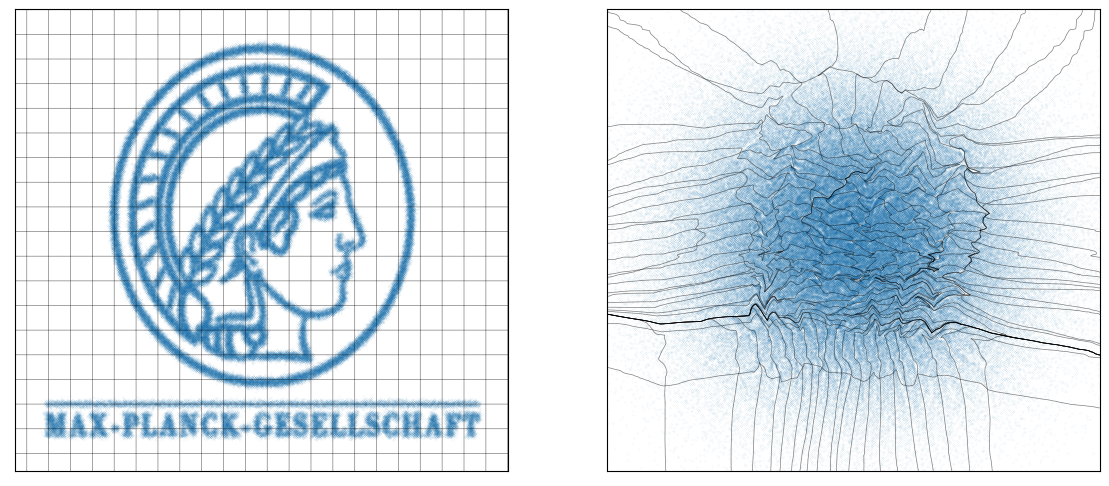

In [11]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
for i in 1:Integer(lc)
    ax[1].plot(grid_logo[1,3+(i-1)*pd:2+i*pd], grid_logo[2,3+(i-1)*pd:2+i*pd], alpha = 0.5, color = "black", linewidth=0.5)
end
ax[1].scatter(smpls[1,:], smpls[2,:], s = 0.0008)
ax[1].set_xlim([minimum(smpls[1,:])-30, maximum(smpls[1,:])+30])
ax[1].set_ylim([minimum(smpls[2,:])-30, maximum(smpls[2,:])+30])
ax[1].get_xaxis().set_visible(false)
ax[1].get_yaxis().set_visible(false)

for i in 1:Integer(lc)
    ax[2].plot(grid_logo_t[1,3+(i-1)*pd:2+i*pd], grid_logo_t[2,3+(i-1)*pd:2+i*pd], alpha = 0.5, color = "black", linewidth=0.5)
end
ax[2].scatter(smpls_t[1,:], smpls_t[2,:], s = 0.0008)
ax[2].set_xlim([-3, 3])
ax[2].set_ylim([-3, 3])
ax[2].get_xaxis().set_visible(false)
ax[2].get_yaxis().set_visible(false)

plt.savefig("mpg_to_norm.svg")

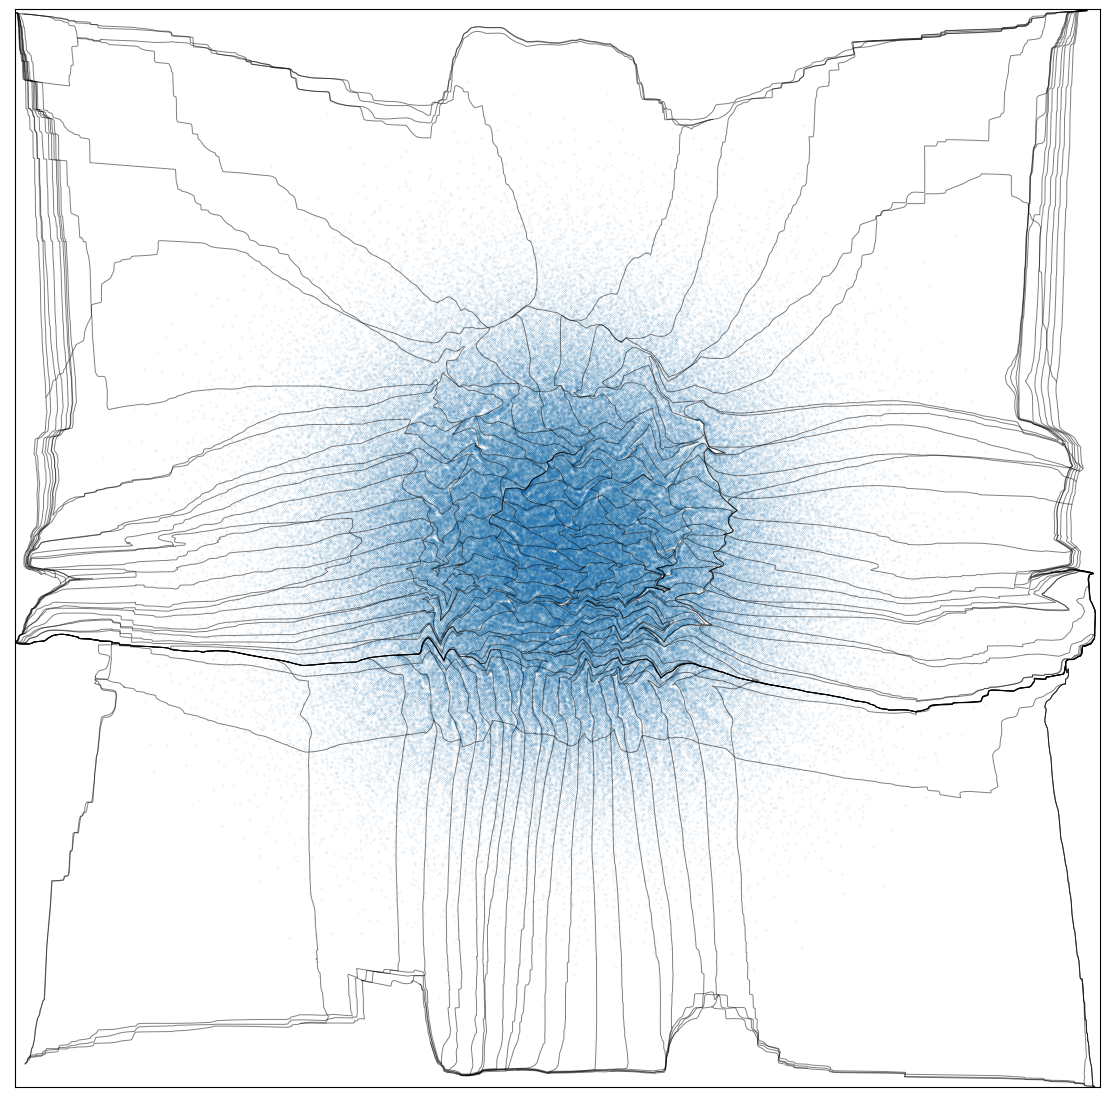

In [14]:
fig, ax = plt.subplots(1,1, figsize=(14,14))
for i in 1:Integer(lc)
    ax.plot(grid_logo_t[1,3+(i-1)*pd:2+i*pd], grid_logo_t[2,3+(i-1)*pd:2+i*pd], alpha = 0.5, color = "black", linewidth=0.7)
end
ax.scatter(smpls_t[1,:], smpls_t[2,:], s = 0.003)
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.get_xaxis().set_visible(false)
ax.get_yaxis().set_visible(false)

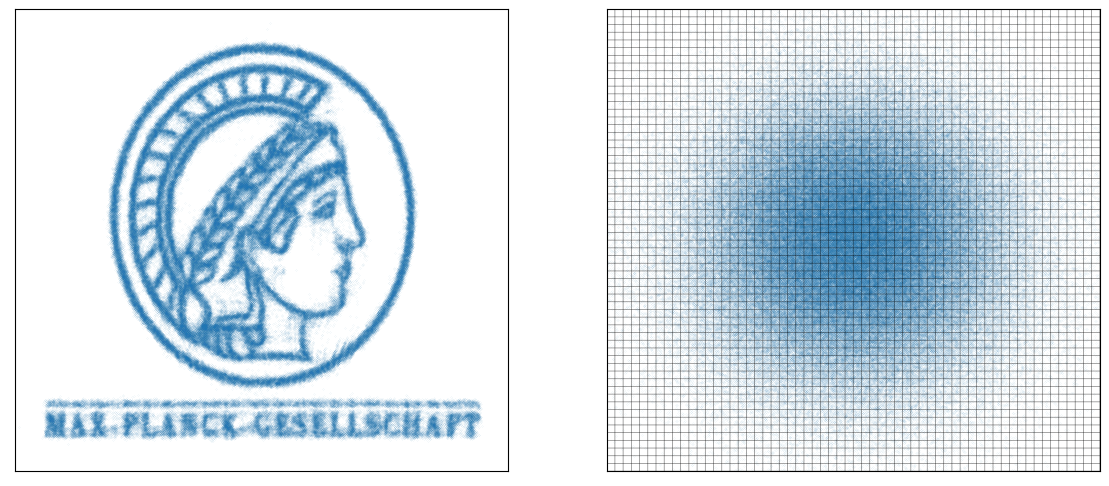

In [28]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
#for i in 1:Integer(lc_n)
#    ax[1].plot(grid_n_t[1,3+(i-1)*pd_n:2+i*pd_n], grid_n_t[2,3+(i-1)*pd_n:2+i*pd_n], alpha = 0.5, color = "black", linewidth=0.5)
#end
ax[1].scatter(smpls_synth[1,:], smpls_synth[2,:], s = 0.0008)
ax[1].set_xlim([minimum(smpls[1,:])-30, maximum(smpls[1,:])+30])
ax[1].set_ylim([minimum(smpls[2,:])-30, maximum(smpls[2,:])+30])
ax[1].get_xaxis().set_visible(false)
ax[1].get_yaxis().set_visible(false)
for i in 1:Integer(lc_n)
    ax[2].plot(grid_n[1,3+(i-1)*pd_n:2+i*pd_n], grid_n[2,3+(i-1)*pd_n:2+i*pd_n], alpha = 0.5, color = "black", linewidth=0.5)
end
ax[2].scatter(normals[1,:], normals[2,:], s = 0.0008)
ax[2].set_xlim([-3, 3])
ax[2].set_ylim([-3, 3])
ax[2].get_xaxis().set_visible(false)
ax[2].get_yaxis().set_visible(false)

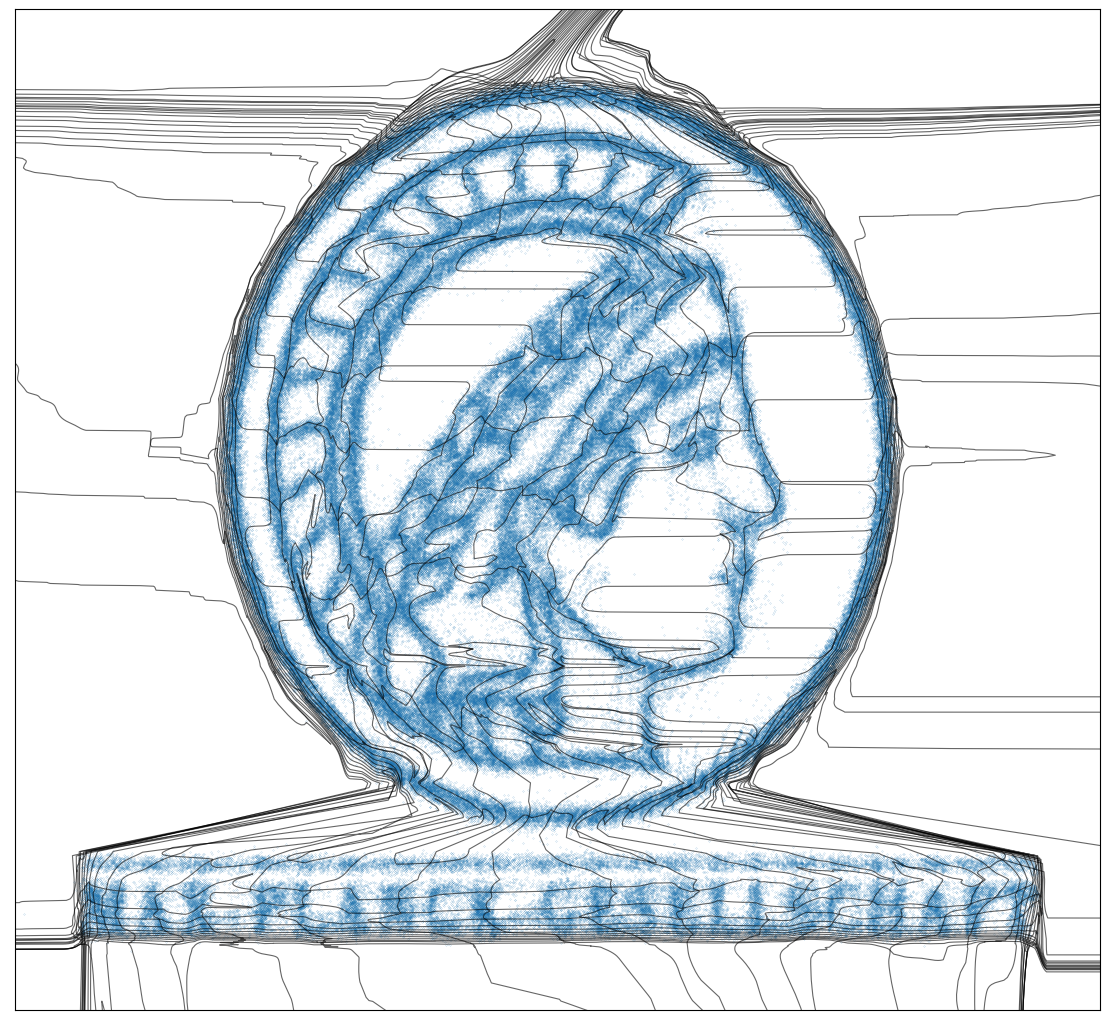

In [18]:
fig, ax = plt.subplots(1,1, figsize=(14,13))
for i in 1:Integer(lc_n)
    ax.plot(grid_n_t[1,3+(i-1)*pd_n:2+i*pd_n], grid_n_t[2,3+(i-1)*pd_n:2+i*pd_n], alpha = 0.6, color = "black", linewidth=0.8)
end
ax.scatter(smpls_synth[1,:], smpls_synth[2,:], s = 0.01)
ax.set_xlim([minimum(smpls[1,:])-30, maximum(smpls[1,:])+30])
ax.set_ylim([minimum(smpls[2,:])-30, maximum(smpls[2,:])+30])
ax.get_xaxis().set_visible(false)
ax.get_yaxis().set_visible(false)

In [439]:
save("/home/iwsatlas1/mdud/RQS_experiments/mpg_flow_data_with_grids.jld2", 
Dict(
"Flow" => cpu.(mpg_flow),
"Samples" => cpu(smpls_flat),
"Samples_transformed" => cpu(smpls_transformed_4),
"Grid_logo" => grid_points,
"Grid_logo_transformed" => transformed_grid_points,
"Grid_normal" => grid_points_normal,
"Grid_normal_transformed" => grid_points_normal_transformed
))